##3.3 Creating a BRDF model

In [5]:
import os
import numpy as np
import itertools
import multiprocessing
import ctypes
from run_start import *
from hips2img import *
%matplotlib inline

##Settings

To create the figure below the illuminations angle has been changed to 45$^{\circ}$

In [7]:
azimuth = np.arange(0, 370, 10)
zenith = -np.arange(-60, 0, 5)
coordinates = np.asarray(list(itertools.product(azimuth, zenith)))

In [ ]:
# http://stackoverflow.com/questions/5549190/is-shared-readonly-data-copied-to-different-processes-for-python-multiprocessing/5550156#5550156

shared_array_base = multiprocessing.Array(ctypes.c_double, len(coordinates) * 3)
shared_array = np.ctypeslib.as_array(shared_array_base.get_obj())
shared_array = shared_array.reshape(len(coordinates), 3)

shared_array[:, :2] = coordinates

def process_(i, def_param=shared_array):
    
    A = shared_array[i, 0]
    Z = shared_array[i, 1]
    
    # create tmeporary camera file
    camera_temp = open('camera/camera_brdf.dat').read()
    with open('camera/camera.{}.temp.dat'.format(i), 'w') as o:
        o.write(camera_temp % {'azi':A, 'zen':Z, 'res':'"output/brdf.{}"'.format(i)})

    # run simulation
    cmd = "echo 14 camera/camera.{}.temp.dat light/brdf_light.dat | \
           start -RATm 5 -RATsensor_wavebands wb/waveband_single.dat \
           obj/birch_tree_scene.obj".format(i)
    error = run_start(cmd)

    shared_array[i, 2] = np.loadtxt('output/brdf.{}.direct'.format(i))[:, 1].sum()

if __name__ == '__main__':

    pool = multiprocessing.Pool(processes=4)
    pool.map(process_, [i for i in range(len(shared_array))])

/Library/Python/2.7/site-packages/numpy-override/numpy/ctypeslib.py:408: RuntimeWarning: Item size computed from the PEP 3118 buffer format string does not match the actual item size.
  return array(obj, copy=False)


In [60]:
brdf_array = shared_array[:, 2].reshape(len(azimuth), len(zenith))

(<matplotlib.figure.Figure at 0x107d039d0>,
 <matplotlib.contour.QuadContourSet instance at 0x107cca0e0>)

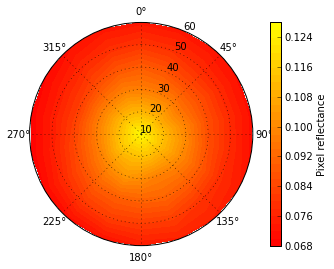

In [61]:
plot_polar_contour(brdf_array, azimuth, zenith)

In [53]:
na = shared_array[shared_array[:, 1] < 50]
az = np.unique(na[:, 0])
zi = np.unique(na[:, 1])
va = na[:, 2].reshape(len(az), len(zi))

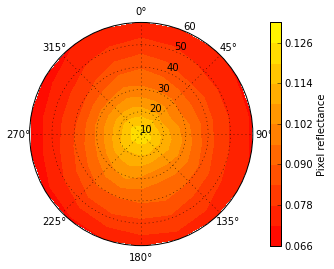

In [62]:
r, theta = np.meshgrid(zenith, np.radians(azimuth))
fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
plt.autumn()
cax = ax.contourf(theta, r, values, 10)
cb = fig.colorbar(cax)
cb.set_label("Pixel reflectance")


In [56]:
na

array([[  0.00000000e+00,   4.00000000e+01,   2.79392651e-01],
       [  0.00000000e+00,   3.00000000e+01,   3.12785658e-01],
       [  0.00000000e+00,   2.00000000e+01,   2.87130419e-01],
       [  0.00000000e+00,   1.00000000e+01,   3.06323837e-01],
       [  2.00000000e+01,   4.00000000e+01,   2.81040649e-01],
       [  2.00000000e+01,   3.00000000e+01,   3.05802854e-01],
       [  2.00000000e+01,   2.00000000e+01,   2.97851863e-01],
       [  2.00000000e+01,   1.00000000e+01,   3.06700874e-01],
       [  4.00000000e+01,   4.00000000e+01,   2.78975110e-01],
       [  4.00000000e+01,   3.00000000e+01,   3.00760379e-01],
       [  4.00000000e+01,   2.00000000e+01,   3.14659243e-01],
       [  4.00000000e+01,   1.00000000e+01,   3.28093037e-01],
       [  6.00000000e+01,   4.00000000e+01,   2.77558007e-01],
       [  6.00000000e+01,   3.00000000e+01,   2.96847006e-01],
       [  6.00000000e+01,   2.00000000e+01,   3.16690563e-01],
       [  6.00000000e+01,   1.00000000e+01,   3.3274165